In [1]:
from google.colab import files


uploaded = files.upload()


Saving marketing.csv to marketing.csv


IMPORTING THE NECESSARY MODULES

In [2]:
import io
import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib
from matplotlib.pyplot import plot
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from scipy.stats import boxcox, yeojohnson
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv(io.BytesIO(uploaded['marketing.csv']))

In [26]:
# Feature Engineering

# 1. Combined expense columns into a single feature: Total_Spending
data['Total_Spending'] = data[
    ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
].sum(axis=1)


# 2. Calculated years since becoming a customer from Dt_Customer as this would be a better feature
data['Customer_Since'] = pd.to_datetime(data['Dt_Customer'], errors='coerce')
data['Customer_Since'] = (pd.Timestamp.now() - data['Customer_Since']).dt.days // 365

# 3. replaced the values in the Marital_Status column
data['Marital_Status']=data['Marital_Status'].replace({'Divorced':1,'Single':1,'Married':2,'Together':2,'Absurd':1,'Widow':1,'YOLO':1, 'Alone':1})

# 4. Created Family_Size by summing Kidhome and Teenhome
data['Family_Size'] = data['Kidhome'] + data['Teenhome'] + data['Marital_Status']

#5. Convert Year_Birth to Age
data['Age'] = 2024 - data['Year_Birth']
# 6. Dropping irrelevant or constant columns
data_cleaned = data.drop(
    columns=[
        'ID',  # Irrelevant column
        'Dt_Customer',  # Original date column replaced by Customer_Since
        'Z_CostContact', 'Z_Revenue',  # Constant columns
        'Kidhome', 'Teenhome', # Original family size columns consolidated into Family_Size
        'Year_Birth'# Original birth year column replaced by Age
    ]
)


# Normalized the numerical columns for clustering later
numerical_columns = ['Income','Marital_Status', 'Total_Spending','Age', 'Family_Size', 'Recency', 'Customer_Since','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
scaler = StandardScaler()
data_cleaned[numerical_columns] = scaler.fit_transform(data_cleaned[numerical_columns])

# Fill missing values for numeric features with the mean
numeric_features = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
# Fill missing values with the mean for numerical features
data_cleaned[numeric_features] = data_cleaned[numeric_features].fillna(data_cleaned[numeric_features].mean())

# Verifying if missing values are handled
missing_values_after = data_cleaned.isnull().sum()
print("\nMissing Values After Filling:")
print(missing_values_after)


Missing Values After Filling:
Education              0
Marital_Status         0
Income                 0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
Total_Spending         0
Customer_Since         0
Family_Size            0
Age                    0
dtype: int64


In [27]:
# Displaying the cleaned dataset structure
print(data_cleaned.head())

    Education  Marital_Status    Income   Recency  MntWines  MntFruits  \
0  Graduation       -1.346874  0.234063  0.307039       635         88   
1  Graduation       -1.346874 -0.234559 -0.383664        11          1   
2  Graduation        0.742460  0.769478 -0.798086       426         49   
3  Graduation        0.742460 -1.017239 -0.798086        11          4   
4         PhD        0.742460  0.240221  1.550305       173         43   

   MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  ...  \
0              546              172                88            88  ...   
1                6                2                 1             6  ...   
2              127              111                21            42  ...   
3               20               10                 3             5  ...   
4              118               46                27            15  ...   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0             0  

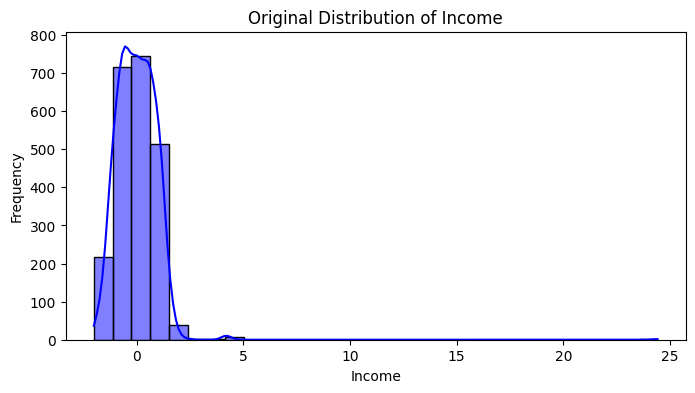

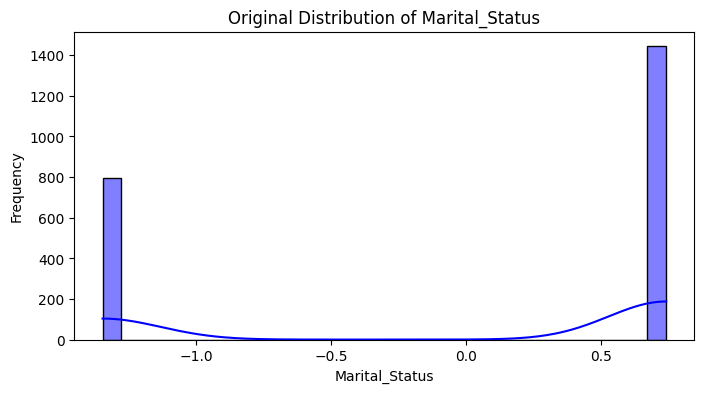

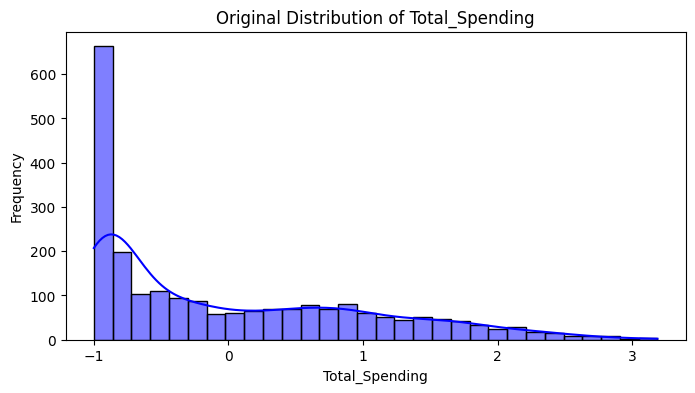

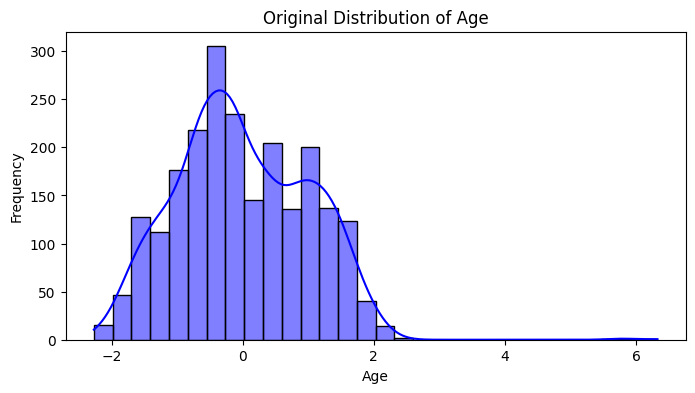

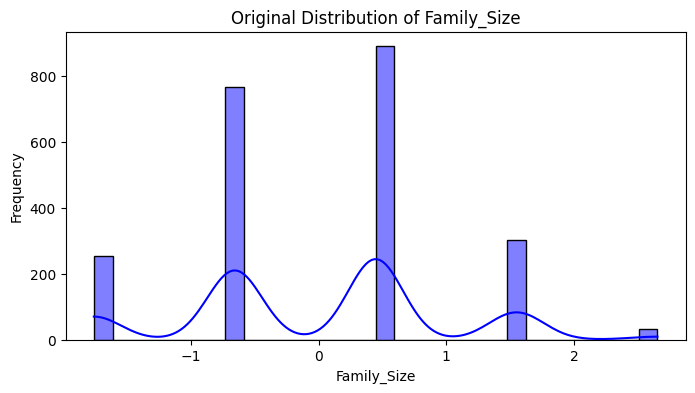

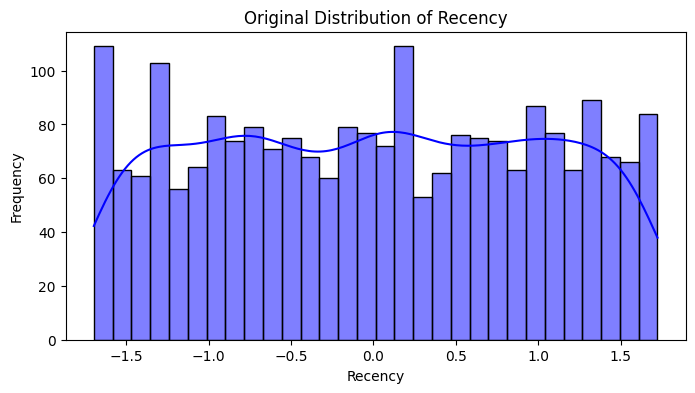

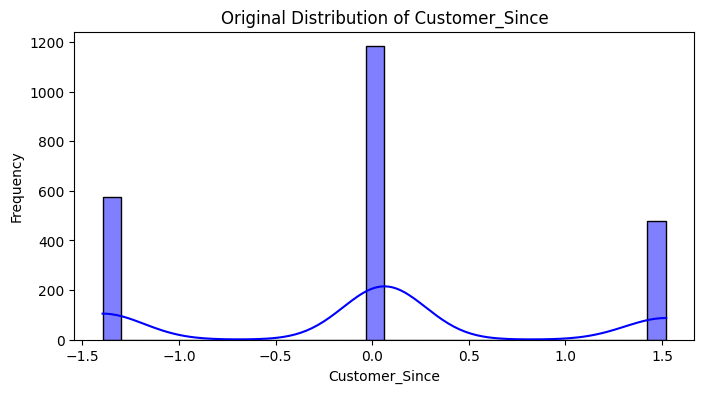

In [28]:
# Features to transform.
# We should transform these features to make them more Gaussian for K-Means to work efficiently
features_to_transform = ['Income','Marital_Status', 'Total_Spending','Age', 'Family_Size', 'Recency', 'Customer_Since']

# Check skewness before transformation
for feature in features_to_transform:
    plt.figure(figsize=(8, 4))
    sns.histplot(data_cleaned[feature], kde=True, bins=30, color='blue')
    plt.title(f'Original Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()



In [29]:
 # Apply Yeo-Johnson Transformation (this makes the features more symmetric and hence gives better cluustering results)
for feature in features_to_transform:
    data_cleaned[feature] = yeojohnson(data_cleaned[feature])

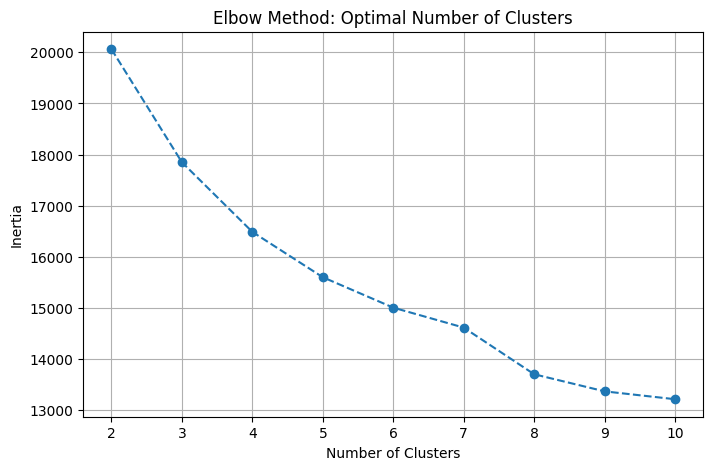

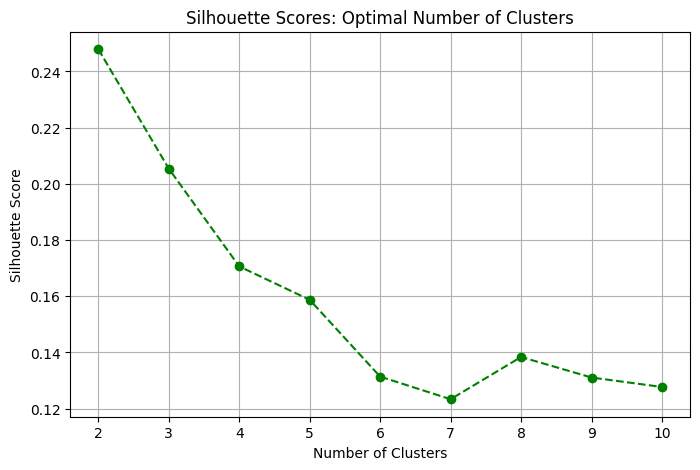

In [30]:
# Selecting only numerical features for clustering
numerical_features = ['Income','Marital_Status', 'Total_Spending','Age', 'Family_Size', 'Recency', 'Customer_Since','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
X = data_cleaned[numerical_features]

# Elbow Method
inertia = []
cluster_range = range(2, 11)  # Testing cluster counts from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Silhouette Scores
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Silhouette Scores: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


We conclude that the optimal number of clusters is 3 based on the elbow method and silhouette scores.

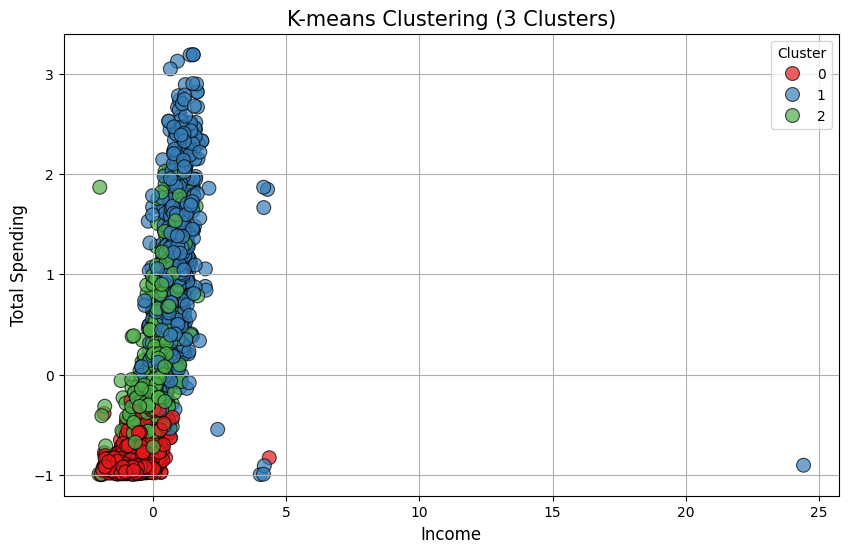

In [31]:
# Performing K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data_cleaned['Cluster'] = kmeans.fit_predict(data_cleaned[numerical_features])

# Visualizing the clusters

plt.figure(figsize=(10, 6))

# Plotting clusters in 2D (using the Income and Total_Spending features)
sns.scatterplot(x=data_cleaned['Income'], y=data_cleaned['Total_Spending'],
                hue=data_cleaned['Cluster'], palette="Set1", s=100, alpha=0.7, edgecolor='black')

plt.title('K-means Clustering (3 Clusters)', fontsize=15)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

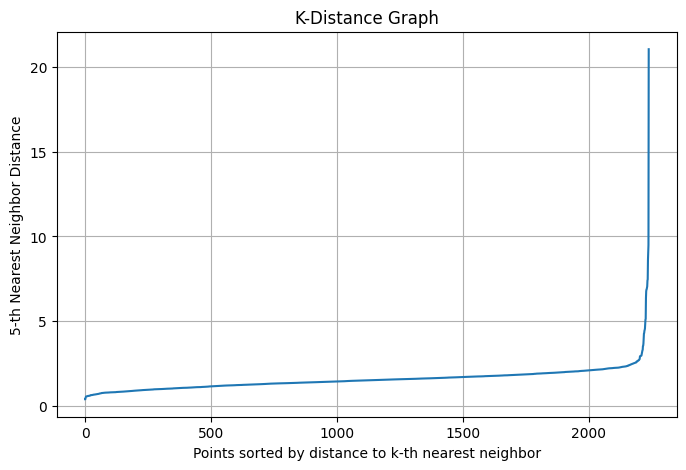

Cluster labels: {0, 1, 2, -1}


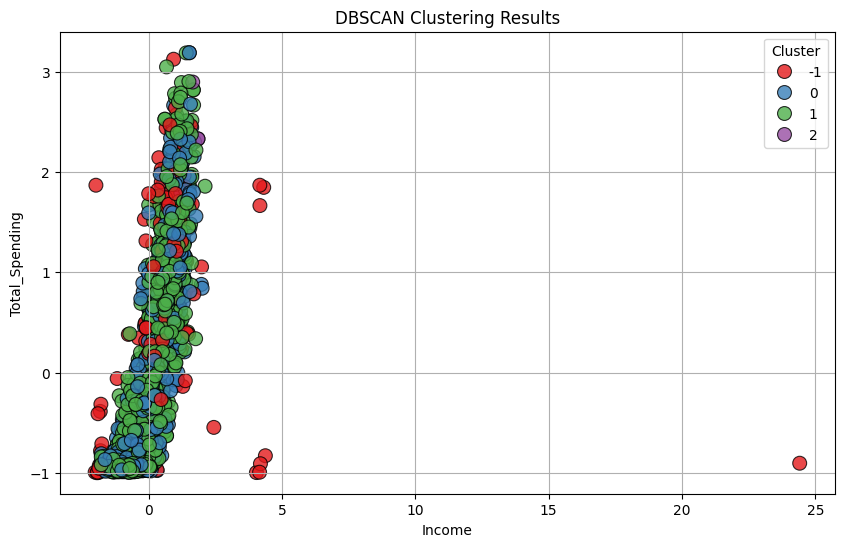

In [35]:
#  DBSCAN Clustering

# 1) Determining the optimal epsilon value

min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_cleaned[numerical_features])
distances, indices = neighbors_fit.kneighbors(data_cleaned[numerical_features])

# Sorted distances for all points to their k-th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot the sorted distances
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

#  We estimate eps = 2 as the optimal value for DBSCAN clustering. This is the distance at which the k-distance graph has a significant change in slope.

# 2) Fitting the DBSCAN model

dbscan = DBSCAN(eps=2, min_samples=5)
data_cleaned['Cluster'] = dbscan.fit_predict(data_cleaned[numerical_features])

# Step 3: Analyzing results
# Print unique cluster labels
print(f"Cluster labels: {set(data_cleaned['Cluster'])}")

# Step 4: Visualize the clusters (using the Income and Total_Spending features)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_cleaned['Income'],
    y=data_cleaned['Total_Spending'],
    hue=data_cleaned['Cluster'],
    palette='Set1',
    s=100,
    alpha=0.8,
    edgecolor='black'
)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Income')
plt.ylabel('Total_Spending')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



We can see that DBSCAN has identified 3 clusters in the data, similar to K-means clustering. The clusters are not well-separated, but DBSCAN is able to identify the outliers effectively.


However, the clusters are not as distinct as in K-means clustering. This is expected as DBSCAN is designed to identify outliers and noise in the data, which may not form well-defined clusters.

In [37]:
# Recommendations:
# Analyze cluster spending patterns
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
data_cleaned['Cluster'] = kmeans.fit_predict(data_cleaned[numerical_features])  # Ensure KMeans clustering results

# Calculating average spending on each product per cluster and also the total average spending for each cluster to extract inferences on types of customers each cluster represents.
cluster_profiles = data.groupby(data_cleaned['Cluster'])[product_columns].mean()
print("Cluster Profiles:\n", cluster_profiles)
cluster_averages = data.groupby(data_cleaned['Cluster'])[['Total_Spending']].mean()
print("Cluster Averages:\n", cluster_averages)

# Define recommendations based on cluster profiles
def get_product_recommendations(cluster_id):
    top_categories = cluster_profiles.loc[cluster_id].sort_values(ascending=False).index.tolist()
    return f"\n Top recommended products for Cluster {cluster_id}: {', '.join(top_categories[:3])}."

# Getting recommendations for each cluster
for cluster_id in cluster_profiles.index:
    recommendations = get_product_recommendations(cluster_id)
    print(recommendations)

Cluster Profiles:
            MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Cluster                                                            
0         38.306693   5.093906        21.464535         7.322677   
1        593.528752  58.201964       395.374474        85.208976   
2        416.891635  23.422053       134.182510        30.366920   

         MntSweetProducts  MntGoldProds  
Cluster                                  
0                5.111888     15.492507  
1               59.438990     71.939691  
2               24.950570     60.471483  
Cluster Averages:
          Total_Spending
Cluster                
0             92.792208
1           1263.692847
2            690.285171

 Top recommended products for Cluster 0: MntWines, MntMeatProducts, MntGoldProds.

 Top recommended products for Cluster 1: MntWines, MntMeatProducts, MntFishProducts.

 Top recommended products for Cluster 2: MntWines, MntMeatProducts, MntGoldProds.


The recommendations are based on the average spending of each cluster on different product categories.

Cluster 0: Top recommended products are Meat Products, Wines, and Gold Products. Moreover, cluster 0 has the lowest average spending and alludes to low frequency buyers.

Cluster 1: Top recommended products are Wines, Meat Products, and Fish Products. This cluster has the highest average spending and is likely composed of high-value customers.

Cluster 2: Top recommended products are Wines, Meat Products, and Gold Products. This cluster has moderate spending on most product categories.